### Some analysis with Forecastability Measures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" # use all for maximum output

from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import pearsonr, kendalltau,spearmanr, normaltest
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.regressor import ResidualsPlot
import sklearn 
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as skl
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import sklearn
print(sklearn.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



0.22.1


In [3]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [4]:
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

In [5]:
df_states.columns

In [6]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)

a = results.extract_result(dset='test')
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

a = a[a[:,0].argsort()] # we sort by first column

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()

b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
b8 = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')

c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 
                     'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'state': df_states['state']})

In [7]:

a = a[a[:,0].argsort()] # we sort by first column
a1 = a1[a1[:,0].argsort()] # we sort by first column
a6 = a6[a6[:,0].argsort()] # we sort by first column
a12 = a12[a12[:,0].argsort()] # we sort by first column

predictions = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1],
                     'CNN_sep_2L_1h': a1[:,1], 
                     'CNN_sep_2L_6h': a6[:,1], 'CNN_sep_2L_12h': a12[:,1],
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Stab1w_wind_speed':c5[:,1], 'Lump1w_wind_speed':c6[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 
                     'Season12h_wind_speed':b7[:,1], 'SpecEnt_wind_speed':b8[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'state': df_states['state']})
predictions = predictions.dropna()

scaler = MinMaxScaler((0, 1))
scaler.fit(predictions[['CNN_sep_2L']])
predictions['CNN_sep_2L_sc'] = scaler.transform(predictions[['CNN_sep_2L']])
scaler.fit(predictions[['CNN_sep_2L_1h']])
predictions['CNN_sep_2L_1h_sc'] = scaler.transform(predictions[['CNN_sep_2L_1h']])
scaler.fit(predictions[['CNN_sep_2L_6h']])
predictions['CNN_sep_2L_6h_sc'] = scaler.transform(predictions[['CNN_sep_2L_6h']])
scaler.fit(predictions[['CNN_sep_2L_12h']])
predictions['CNN_sep_2L_12h_sc'] = scaler.transform(predictions[['CNN_sep_2L_12h']])

In [8]:
predictions = predictions.dropna()
def correlaciones(predictions, measure, prediction_horizon):
    print("============")
    print(measure, prediction_horizon, " corr: ", predictions[prediction_horizon].corr(predictions[measure]),
          "R2: ", r2_score(predictions[prediction_horizon], predictions[measure]))
    print("============")
    return

correlaciones(predictions, 'Trend12h_wind_speed', 'CNN_sep_2L')
correlaciones(predictions, 'SpecEnt_wind_speed', 'CNN_sep_2L')
predictions['new_measure'] = - predictions['SpecEnt_wind_speed'] + predictions['Trend12h_wind_speed']
correlaciones(predictions, 'new_measure','CNN_sep_2L')

Trend12h_wind_speed CNN_sep_2L  corr:  0.8339454041567858 R2:  -67.27476685394456
SpecEnt_wind_speed CNN_sep_2L  corr:  -0.8308333559942153 R2:  -19.93228140091114
new_measure CNN_sep_2L  corr:  0.853622228000644 R2:  -467.51604203879515


In [9]:
data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
r2_score(data['CNN_sep_2L'],data['Trend12h_wind_speed'])

In [10]:
# ñapa
from sklearn.preprocessing import MinMaxScaler
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation sin scalar',correlation, r2_score(data['CNN_sep_2L'],data['Trend24h_wind_speed']))

scaler = MinMaxScaler((0, 1))
scaler.fit(data[['CNN_sep_2L']])

data['prediction'] = scaler.transform(data[['CNN_sep_2L']])

print('correlation scaled',correlation, r2_score(data['prediction'], data['Trend24h_wind_speed']))

correlation sin scalar 0.8339406237157402 -69.65297103041425
correlation scaled 0.8339406237157402 0.5706860674568723


In [11]:
print(data.columns)

Index(['test', 'CNN_sep_2L', 'Trend12h_wind_speed', 'Trend24h_wind_speed',
       'Trend1m_wind_speed', 'Season24h_wind_speed', 'Season1m_wind_speed',
       'Season12h_wind_speed', 'SampEnt_wind_speed', 'state', 'prediction'],
      dtype='object')


In [12]:
data['Trend24h_wind_speed']

In [13]:
# Table 3
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation FT 12h',correlation, 'R2', r2_score(data['prediction'], data['Trend12h_wind_speed']))

correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation FT 24h', correlation, 'R2', r2_score(data['prediction'], data['Trend24h_wind_speed']))

correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation FT 1m ',correlation, 'R2', r2_score(data['prediction'], data['Trend1m_wind_speed']))
print('--------------')
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation ST 12h',correlation, 'R2', r2_score(data['prediction'], data['Season12h_wind_speed']))
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation ST 24h',correlation, 'R2', r2_score(data['prediction'], data['Season24h_wind_speed']))
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation ST 1m',correlation, 'R2', r2_score(data['prediction'], data['Season1m_wind_speed']))

correlation FT 12h 0.8339406237157402 R2 -0.48740658989628116
correlation FT 24h 0.8877958718582855 R2 0.5706860674568723
correlation FT 1m  0.4731308595102287 R2 -16.175221564115162
--------------
correlation ST 12h -0.19903601717908878 R2 -9.56696660661943
correlation ST 24h 0.15317702490726845 R2 -5.443003663103811
correlation ST 1m -0.04208742984171607 R2 -8.783007111751374


In [14]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

df_tmp = pd.DataFrame({'x':a[:,1], 'trend': ys[:,0], 'season': zs[:,0]})

correlation_trend = pearsonr(a[:,1],ys[:,0])
correlation_season = pearsonr(a[:,1],zs[:,0])
print('correlation seasonal least squares 24h', correlation_season)
print('correlation trend least squares 24h', correlation_trend)

correlation seasonal least squares 24h (0.10995214396437283, 0.0)
correlation trend least squares 24h (0.8414067852374699, 0.0)


In [15]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':b1[:,1], 'Trend12h_wind_speed':b2[:,1], 'Trend1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation Trend24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation Trend12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation Trend1m',correlation)

correlation Trend24h 0.8877958718582855
correlation Trend12h 0.8339406237157402
correlation Trend1m 0.4731308595102287


In [16]:
measure.measures

In [17]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Season24h_wind_speed':b1[:,1], 'Season12h_wind_speed':b2[:,1], 'Season1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation season24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation Season12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation Season1m',correlation)

correlation season24h 0.15317702490726845
correlation Season12h -0.19903601717908878
correlation Season1m -0.04208742984171607


correlation (0.8877958718582878, 0.0)


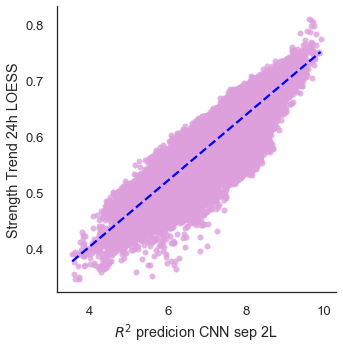

In [18]:
# Strength Trend LOESS
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1], b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_trend_LOESS.png', dpi=300)
snsplot.savefig('e:/figures/Strength_trend_LOESS.pdf')

In [19]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend_strength_wind_speed':ys[:,0], 'strenght_seasonality_wind_speed':zs[:,0]})
correlation = data['CNN_sep_2L'].corr(data['Trend_strength_wind_speed'])
print('correlation Trend_strength_wind_speed',correlation)

correlation = data['CNN_sep_2L'].corr(data['strenght_seasonality_wind_speed'])
print('strenght_seasonality_wind_speed',correlation)


correlation Trend_strength_wind_speed 0.8414067852374743
strenght_seasonality_wind_speed 0.1099521439643725


correlation (0.8414067852374699, 0.0)


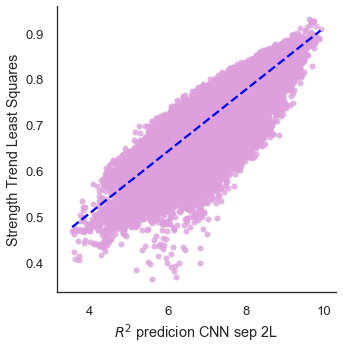

In [20]:
# Grafico de Strenght trend  least squares (como thesis)
import matplotlib.pylab as plt
df_tmp = pd.DataFrame({'x':a[:,1], 'y': ys[:,0]})

correlation = pearsonr(a[:,1],ys[:,0])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})

snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend Least Squares')
snsplot.savefig('e:/figures/Strength_trend_Least_squares.png', dpi=300)

correlation (0.10995214396437283, 0.0) -79.83229830556509


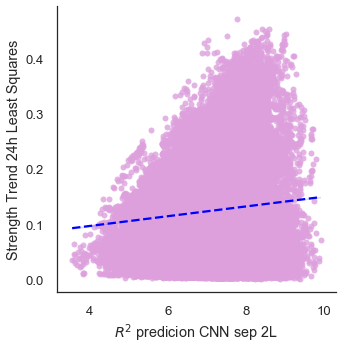

In [21]:
# grafico de Seasonality strhngth 24h least squares

df_tmp = pd.DataFrame({'x':a[:,1], 'y': zs[:,0]})

correlation = pearsonr(a[:,1],zs[:,0])
print('correlation',correlation, r2_score(a[:,1],zs[:,0]))

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h Least Squares')
snsplot.savefig('e:/figures/Strength_Seasonal_Least_squares.png', dpi=300)

correlation (0.15317702490727572, 0.0)


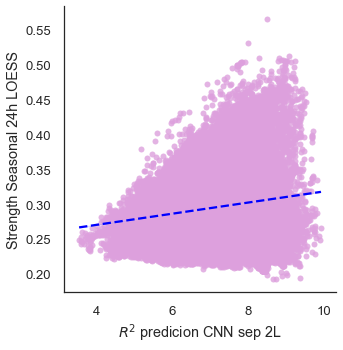

In [22]:
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1],b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Seasonal 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_Seasonal_LOESS.png', dpi=300)

In [23]:
# Creamos dataframe con las dos medidas St_LOESS y St_LSQ
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')
b1 = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
zs = df_states[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'St_LOESS':b1[:,1], 'St_LSQ':zs[:,0], 'state': df_states['state']})

In [24]:
data.columns

In [25]:
# correlations between LOESS and ...
df = data

states = ["AL", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", 
          "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "ER"]
# DC, Alaska and Hawaii have no sites (AK, HI, DC)
print('SpecEnt_wind_speed')
for st in states:

    pdX = df[((df['state']==st))  ]
    correlation1 = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
    correlation2 = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
    n = pdX.shape[0]
    print(st,'-', round(correlation1, 3), round(correlation2, 3), 'state_sites', n+1)

SpecEnt_wind_speed
AL - 0.803 0.838 state_sites 89
AZ - 0.783 0.845 state_sites 2376
AR - 0.768 0.808 state_sites 823
CA - 0.837 0.897 state_sites 4053
CO - 0.81 0.851 state_sites 3652
CT - 0.882 0.886 state_sites 156
DE - 0.915 0.899 state_sites 151
FL - 0.726 0.73 state_sites 1040
GA - 0.54 0.485 state_sites 273
ID - 0.835 0.879 state_sites 1451
IL - 0.393 0.555 state_sites 5253
IN - 0.881 0.914 state_sites 3195
IA - 0.639 0.733 state_sites 5253
KS - 0.923 0.935 state_sites 4150
KY - 0.801 0.83 state_sites 347
LA - 0.879 0.879 state_sites 558
ME - 0.907 0.92 state_sites 1201
MD - 0.952 0.963 state_sites 334
MA - 0.914 0.914 state_sites 676
MI - 0.606 0.71 state_sites 3609
MN - 0.81 0.841 state_sites 6372
MS - 0.797 0.876 state_sites 187
MO - 0.816 0.883 state_sites 1836
MT - 0.905 0.924 state_sites 4091
NE - 0.89 0.911 state_sites 3708
NV - 0.795 0.855 state_sites 3865
NH - 0.854 0.876 state_sites 409
NJ - 0.912 0.907 state_sites 483
NM - 0.852 0.885 state_sites 6584
NY - 0.879 0.898

correlation FT LOESS 0.9456901065621138
correlation FT Least Squares 0.9368053949463422


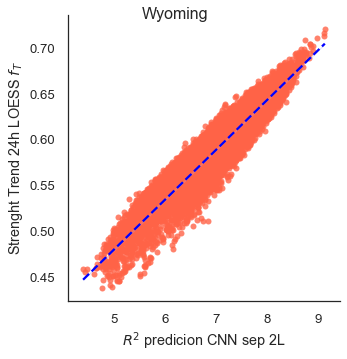

In [26]:
# Mapa de Wyoming
df = data
pdX = df[(df['state']=='WY')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wyoming", fontsize=16)

snsplot.savefig('e:/figures/F2_Wyoming.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

correlation FT LOESS 0.5548201425505271
correlation FT Least Squares 0.392852740693512


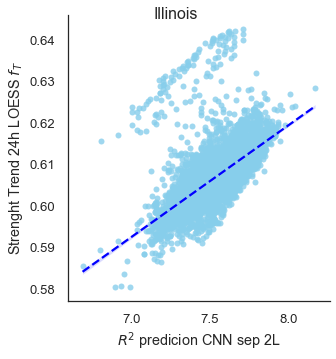

In [27]:
# Mapa de Illinois
df = data
pdX = df[(df['state']=='IL')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Illinois", fontsize=16)

snsplot.savefig('e:/figures/F2_Illinois.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

correlation FT LOESS 0.923968222866522
correlation FT Least Squares 0.9049892001814254


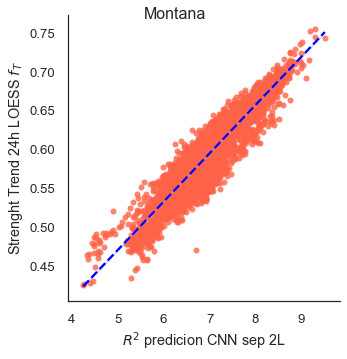

In [28]:
# Mapa de Montana
df = data
pdX = df[(df['state']=='MT')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Montana", fontsize=16)

snsplot.savefig('e:/figures/F2_Montana.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

correlation FT LOESS 0.6267344560720921
correlation FT Least Squares 0.5001890013181028


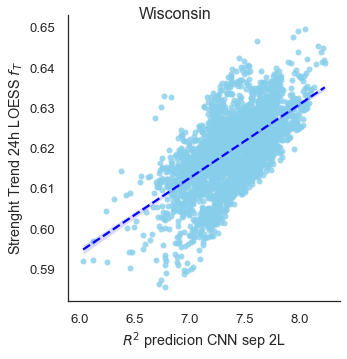

In [29]:
# Mapa de Illiinois
df = data
pdX = df[(df['state']=='WI')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wisconsin", fontsize=16)

snsplot.savefig('e:/figures/F2_Wisconsin.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

### Regressions

#### simple sklearn regression

In [30]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression', 'CNN_sep_2L_1h' )

# 6h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_6h']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression', 'CNN_sep_2L_6h' )

# 12h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_12h']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression', 'CNN_sep_2L_12h' )

Intercept: 
 0.3747386905889755
Coefficients: 
 [ 0.84967989 -0.00569453]
regression CNN_sep_2L_1h  corr:  0.9064716648941861 R2:  0.8216908792560547
Intercept: 
 2.766569038650628
Coefficients: 
 [ 5.37320309 -0.1432888 ]
regression CNN_sep_2L_6h  corr:  0.922523071157045 R2:  0.8510488168170144
Intercept: 
 9.357093468118451
Coefficients: 
 [ 9.1568999 -0.6952496]
regression CNN_sep_2L_12h  corr:  0.9181285178118812 R2:  0.8429599752194894


### Statsmodel Regression

In [31]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression','CNN_sep_2L_1h' )

# 6h ahead
Y = predictions['CNN_sep_2L_6h']
X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression', 'CNN_sep_2L_6h')

#12h ahead
Y = predictions['CNN_sep_2L_12h']
X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression', 'CNN_sep_2L_12h')


regression CNN_sep_2L_1h  corr:  0.9064716648941878 R2:  0.8216908792560547
regression CNN_sep_2L_6h  corr:  0.922523071157048 R2:  0.8510488168170144
regression CNN_sep_2L_12h  corr:  0.918128517811879 R2:  0.8429599752194894


### LASSO Regression

In [32]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_1h')

# 6h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_6h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_6h')

# 12h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_12h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_12h')



[ 0.0835211  -0.07450605] 1.5759241419641001 21
R2 0.5653915298746153
ojo 0.5653915298746153
lasso CNN_sep_2L_1h  corr:  0.7569021109074925 R2:  0.5653915298746153
[ 4.60747385 -0.21205859] 3.967046981528919 16
R2 0.8457908792667107
ojo 0.8457908792667107
lasso CNN_sep_2L_6h  corr:  0.9205982732546409 R2:  0.8457908792667107
[ 8.39166238 -0.76397162] 10.556761510799607 17
R2 0.8418850198217691
ojo 0.8418850198217691
lasso CNN_sep_2L_12h  corr:  0.9176766960247021 R2:  0.8418850198217691


In [ ]:
df_NM1 = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM1})
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),
                     data=df_NM1, 
                     robust=True, scatter_kws={"color": "skyblue"}, 
                     line_kws={"color": "blue", "ls":"--"})

snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','$f_t$ + $SapecEnt$')
snsplot.fig.suptitle('LASSO linear regression')
snsplot.savefig('e:/figures/regression_LASSO.png', dpi=300)

### LASSO ALL

In [33]:
#1h ahead
Y = predictions['CNN_sep_2L_1h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_1h')

#6h ahead
Y = predictions['CNN_sep_2L_6h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_6h')

#12h ahead
Y = predictions['CNN_sep_2L_12h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso', 'CNN_sep_2L_12h')

[ 0.         -0.         -0.12061825 -0.0729688  -0.01030627 -0.01977899
  0.         -0.        ] 1.7395379152538546 32
R2 0.6607456633287783
ojo 0.6607456633287783
lasso CNN_sep_2L_1h  corr:  0.8211933249003697 R2:  0.6607456633287783
[ 2.12495805  0.         -0.54155041 -0.3096844  -0.10592761 -0.14396476
  1.98577939 -0.        ] 5.812833662146353 152
R2 0.8940106588174548
ojo 0.8940106588174548
lasso CNN_sep_2L_6h  corr:  0.9465238784829223 R2:  0.8940106588174548
[ 8.47561352  2.18269303 -0.68199997 -0.68860686 -0.13378298  0.
  0.         -0.        ] 9.817755166384512 45
R2 0.8801513043126483
ojo 0.8801513043126483
lasso CNN_sep_2L_12h  corr:  0.9383866753016524 R2:  0.8801513043126483


In [ ]:
df_NM1 = pd.DataFrame({'CNN_sep_2L': predictions['CNN_sep_2L_12h'], 'New Measure': NM1})
fig = snsplot.fig 
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig.suptitle("LASSO feature selection ", fontsize=16)
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),
                     data=df_NM1, 
                     robust=True, scatter_kws={"color": "skyblue"}, 
                     line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Feature selected')
snsplot.savefig('e:/figures/regression_feature_selection_LASSO.png', dpi=300)

### SVM 

In [34]:
# reducing epsilon we obtain better results

In [35]:
# 1 h
Y = predictions['CNN_sep_2L_1h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                     'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
#svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
svm_rgr = SVR(C=1.0, epsilon=0.01, kernel='rbf')
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L_1h')
correlation = predictions['CNN_sep_2L_1h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

# 6 h
Y = predictions['CNN_sep_2L_6h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                     'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
#svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
svm_rgr = SVR(C=1.0, epsilon=0.01, kernel='rbf')
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L_6h')
correlation = predictions['CNN_sep_2L_6h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

# 12 h
Y = predictions['CNN_sep_2L_12h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                     'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
#svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
svm_rgr = SVR(C=1.0, epsilon=0.2, kernel='rbf')
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L_12h')
correlation = predictions['CNN_sep_2L_12h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

0.9507318848754126
SVM CNN_sep_2L_1h  corr:  0.9751212292299303 R2:  0.9507318848754125
R2 regression 0.9507318848754126 correlation 0.9751212292299303
0.9342525378827413
SVM CNN_sep_2L_6h  corr:  0.9667417379371254 R2:  0.9342525378827413
R2 regression 0.9342525378827413 correlation 0.9667417379371254
0.8913940595466757
SVM CNN_sep_2L_12h  corr:  0.9441680282559879 R2:  0.8913940595466757
R2 regression 0.8913940595466757 correlation 0.9441680282559879


### Selection best Epsilon for each horizon

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm


In [39]:

svm_rgr = SVR(C=1.0, epsilon=0.01, kernel='rbf')
def svr_param_selection (x,y, nfolds):
    Cs = [1.0]
    epsilons = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
    param_grid = {'C': Cs, 'epsilon' : epsilons}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv = nfolds, verbose = 4)
    grid_search.fit(x,y)
    return grid_search.best_params_

#12h
Y = predictions['CNN_sep_2L_12h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 
                     'Stab1w_wind_speed',  'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]

print(svr_param_selection(X,Y,2))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] C=1.0, epsilon=0.01 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=1.0, epsilon=0.01, score=0.873, total= 4.1min
[CV] C=1.0, epsilon=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s


[CV] ................. C=1.0, epsilon=0.01, score=0.795, total= 8.3min
[CV] C=1.0, epsilon=0.05 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s


[CV] ................. C=1.0, epsilon=0.05, score=0.873, total= 6.4min
[CV] C=1.0, epsilon=0.05 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.8min remaining:    0.0s


[CV] ................. C=1.0, epsilon=0.05, score=0.795, total= 8.8min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] .................. C=1.0, epsilon=0.1, score=0.874, total= 5.6min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] .................. C=1.0, epsilon=0.1, score=0.789, total= 7.1min
[CV] C=1.0, epsilon=0.15 .............................................
[CV] ................. C=1.0, epsilon=0.15, score=0.875, total= 5.1min
[CV] C=1.0, epsilon=0.15 .............................................
[CV] ................. C=1.0, epsilon=0.15, score=0.784, total= 3.9min
[CV] C=1.0, epsilon=0.2 ..............................................
[CV] .................. C=1.0, epsilon=0.2, score=0.876, total= 4.1min
[CV] C=1.0, epsilon=0.2 ..............................................
[CV] .................. C=1.0, epsilon=0.2, score=0.777, total= 3.7min
[CV] C=1.0, epsilon=0.25 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 70.7min finished


{'C': 1.0, 'epsilon': 0.01}


In [40]:
# 12 h
Y = predictions['CNN_sep_2L_12h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                     'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
#svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
svm_rgr = SVR(C=1.0, epsilon=0.2, kernel='rbf')
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L_12h')
correlation = predictions['CNN_sep_2L_12h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

0.8913940595466757
SVM CNN_sep_2L_12h  corr:  0.9441680282559879 R2:  0.8913940595466757
R2 regression 0.8913940595466757 correlation 0.9441680282559879


In [ ]:
# NM.values -> y_hat
# df_multi.x -> predictions.CNN_sep_2L_12h

In [73]:
# no ejecutar faltan predictions del svm
# figure with best combination
sns.set(rc={'figure.figsize':(8,8)})

df_NMa = pd.DataFrame({'CNN_sep_2L': predictions['CNN_sep_2L_12h'], 'New Measure': NM.values})
sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.regplot(x='CNN_sep_2L', y='New Measure', data=df_NMa, 
                     scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "lw":1}, lowess=True)

snsplot.set(xlabel='$R^2$ predicion CNN sep 2L', ylabel='$f_t$ + $SapecEnt$',title = "Linear Regression LOESS")


snsplot.figure.savefig('e:/figures/regression_loess(with_lowess).png', dpi=300)

NameError: name 'df_multi1' is not defined

### disgressions 

In [74]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a=results.extract_result(dset='test')

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()
a = a[a[:,0].argsort()] # we sort by first column

# Use Sampent and TrendLoess
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')

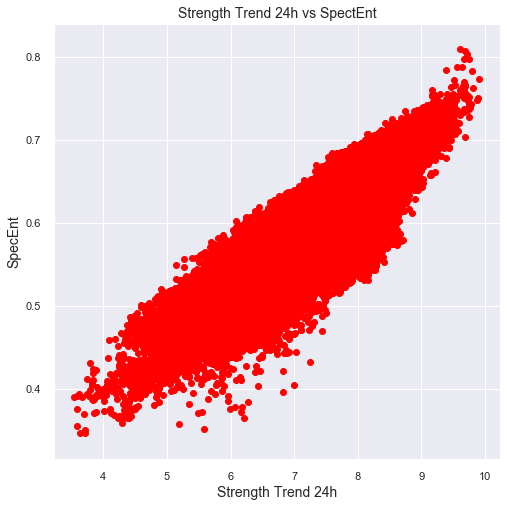

In [75]:
# obtaining correlations linear regression

df_multi = pd.DataFrame({'x':a[:,1], 'y': b[:,1], 'z' : c[:,1]})

plt.scatter(df_multi['x'], df_multi['y'], color='red')
plt.title('Strength Trend 24h vs SpectEnt', fontsize=14)
plt.xlabel('Strength Trend 24h', fontsize=14)
plt.ylabel('SpecEnt', fontsize=14)
plt.grid(True)
plt.show()

In [76]:
# por alguna razon oscura SpecEnt tiene 15 o 20 nulls
# hacemos una ñapa y eliminamos las filas
tmp = df_multi['z'].notnull()
df_multi1 = df_multi[tmp]

### Sklearn linear regression

In [77]:
from sklearn import linear_model
import statsmodels.api as skl

X = df_multi1[['y', 'z']]
Y = df_multi1['x']

In [78]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 9.357093468118451
Coefficients: 
 [ 9.1568999 -0.6952496]


In [79]:
# new measure

NM  = regr.intercept_ + regr.coef_[0] * df_multi1['y'] + regr.coef_[1] * df_multi1['z']

In [82]:
correlation = df_multi1['x'].corr(NM)
correlation1 = df_multi1['x'].corr(df_multi1['y'])
correlation2 = df_multi1['x'].corr(df_multi1['z'])
print('correlation x - NM :',correlation, r2_score(df_multi1['x'],NM))
print('correlation x - y  :', correlation1, r2_score(df_multi1['y'],NM))
print('correlation x - z  :', correlation2, r2_score(df_multi1['z'],NM))
predictions['regression'] = NM
correlaciones(predictions, 'regression', 'CNN_sep_2L_12h')

correlation x - NM : 0.9181285178118812 0.8429599752194894
correlation x - y  : 0.8877898705192981 -15967.317297502066
correlation x - z  : -0.8308333559942153 -74.59663229669897
regression CNN_sep_2L_12h  corr:  0.9181285178118812 R2:  0.8429599752194894


In [83]:
print(df_multi1['y'], NM) # para calcular bien el R2 hay que scalar el resultado entre 0 y 1?

0         0.803795
1         0.695409
2         0.665712
3         0.665139
4         0.665125
            ...   
126687    0.705733
126688    0.559848
126689    0.748292
126690    0.699168
126691    0.744178
Name: y, Length: 126661, dtype: float64 0         10.070698
1          8.655822
2          8.097642
3          8.098488
4          8.102194
            ...    
126687     8.811938
126688     6.889725
126689     9.231661
126690     8.751746
126691     9.198175
Length: 126661, dtype: float64


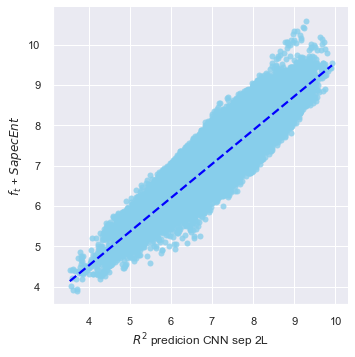

In [84]:
fig = snsplot.fig 
sns.set(font_scale=1.2)
sns.set_style(style='white')
sns.set(rc={'figure.figsize':(12,12)})
df_NM = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM.values})
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=df_NM, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','$f_t$ + $SapecEnt$')
fig.suptitle("Linear Regression", fontsize=16)
snsplot.savefig('e:/figures/regression_1(loess).png', dpi=300)

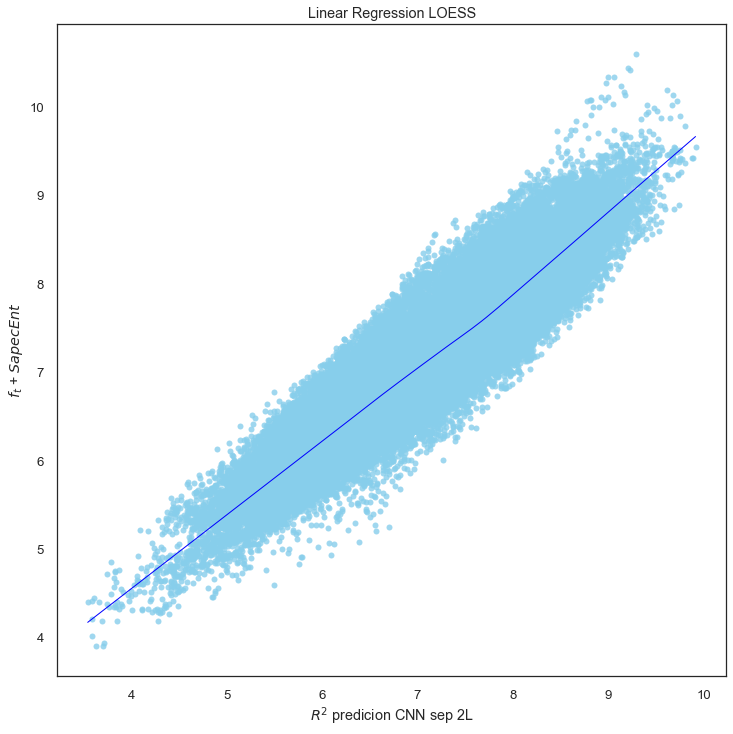

In [85]:
sns.set(rc={'figure.figsize':(12,12)})

df_NMa = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM.values})
sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.regplot(x='CNN_sep_2L', y='New Measure', data=df_NMa, 
                     scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "lw":1}, lowess=True)

snsplot.set(xlabel='$R^2$ predicion CNN sep 2L', ylabel='$f_t$ + $SapecEnt$',title = "Linear Regression LOESS")


snsplot.figure.savefig('e:/figures/regression_loess(with_lowess).png', dpi=300)



### Statsmodel linear regression

### Lasso Linear Regression with selected measures

In [95]:
measure.measures

In [96]:
c1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
c3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
c4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')
c7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
c8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':c1[:,1], 'Season24h_wind_speed':c2[:,1], 
                     'SampEnt_wind_speed':c3[:,1], 'SpecEnt_wind_speed':c4[:,1], 'Stab1w_wind_speed':c5[:,1],
                    'Lump1w_wind_speed':c6[:,1],
                     'Trend12h_wind_speed':c7[:,1], 'Season12h_wind_speed':c8[:,1],
                    })
data = data.dropna()

In [97]:
Y = data['CNN_sep_2L']
X = data[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]


In [98]:
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)

print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM2 = model_lasso.predict(X)
print('R2',model_lasso.score(X,Y))

[ 8.47561352  2.18269303 -0.68199997 -0.68860686 -0.13378298  0.
  0.         -0.        ] 9.817755166384512 45
R2 0.8801513043126483


In [99]:
df_NM2 = pd.DataFrame({'CNN_sep_2L': data.CNN_sep_2L, 'New Measure': NM2})

correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
print(correlation)

0.9383866753016524


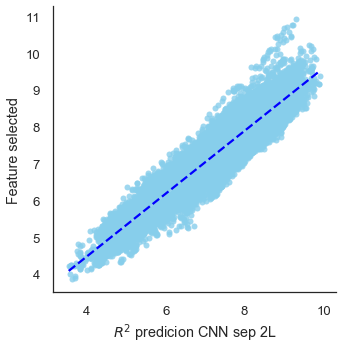

In [101]:
#fig = snsplot.fig 
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig.suptitle("LASSO feature selection ", fontsize=16)
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=df_NM2, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Feature selected')
snsplot.savefig('e:/figures/regression_feature_selection_LASSO.png', dpi=300)

### Testing if the distributions are normal

In [102]:
# D’Agostino’s K^2 Test

data = a[:,1]
data = c1[:,1]

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=5303.489, p=0.000
Sample does not look Gaussian (reject H0)


In [103]:
# anderson darling
from scipy.stats import anderson
# normality test
data = c1[:,1]
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
   sl, cv = result.significance_level[i], result.critical_values[i]
   if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
   else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 847.147
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [104]:
#kolmogorov smirnoff
from scipy.stats import kstest
data = c1[:,1]
data = np.random.normal(0, 1, 100000)
kstest(data, 'norm')


In [105]:
# shapiro - wilcox
from scipy.stats import shapiro
data = c1[:,1]
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.981, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



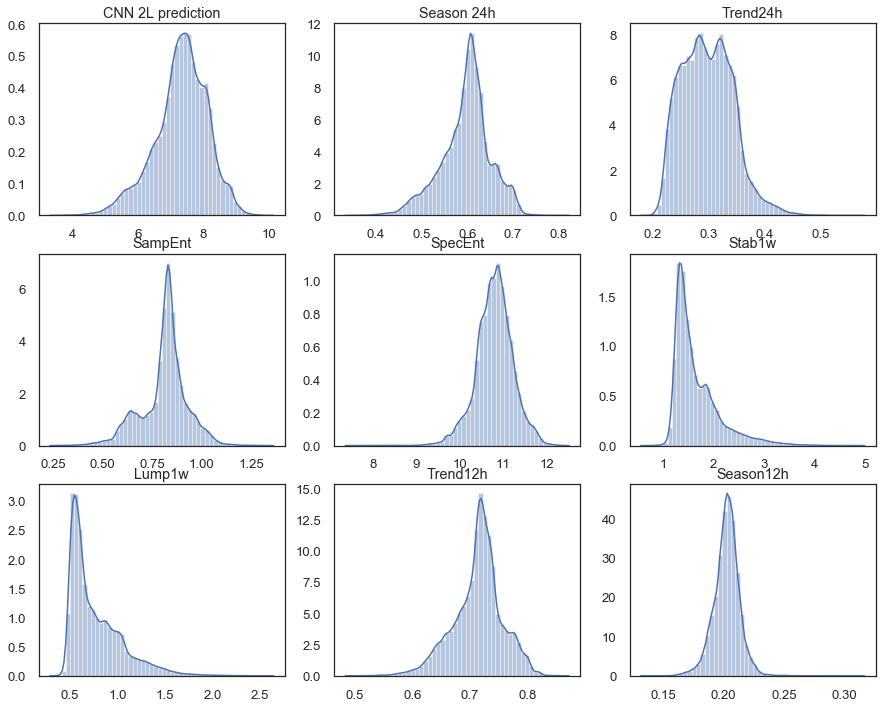

In [106]:
# dibujamos las distribuciones toas toas
plt.rcParams['figure.figsize'] = (15.0, 12.0)
f, axes = plt.subplots(3,3)
sns.distplot(a[:,1], label='CNN 2L prediction', kde=True, norm_hist=True, ax=axes[0,0]).set_title('CNN 2L prediction')
sns.distplot(c1[:,1], label='Season 24h', kde=True, norm_hist=True, ax=axes[0,1]).set_title('Season 24h')
sns.distplot(c2[:,1], label='Trend 24h', kde=True, norm_hist=True, ax=axes[0,2]).set_title('Trend24h')
sns.distplot(c3[:,1], label='SampEnt', kde=True, norm_hist=True, ax=axes[1,0]).set_title('SampEnt')
sns.distplot(c4[:,1], label='SpecEnt', kde=True, norm_hist=True, ax=axes[1,1]).set_title('SpecEnt')
sns.distplot(c5[:,1], label='Stab1w', kde=True, norm_hist=True, ax=axes[1,2]).set_title('Stab1w')
sns.distplot(c6[:,1], label='Lump1w', kde=True, norm_hist=True, ax=axes[2,0]).set_title('Lump1w')
sns.distplot(c7[:,1], label='Trend12h', kde=True, norm_hist=True, ax=axes[2,1]).set_title('Trend12h')
sns.distplot(c8[:,1], label='Season12h', kde=True, norm_hist=True, ax=axes[2,2]).set_title('Season12h')

### A Feature selection try with Lasso

In [107]:
c1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
c3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
c4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')
c7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
c8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':c1[:,1], 'Season24h_wind_speed':c2[:,1], 
                     'SampEnt_wind_speed':c3[:,1], 'SpecEnt_wind_speed':c4[:,1], 'Stab1w_wind_speed':c5[:,1],
                    'Lump1w_wind_speed':c6[:,1],
                     'Trend12h_wind_speed':c7[:,1], 'Season12h_wind_speed':c8[:,1],
                    })
data = data.dropna()
data = data.dropna()
Y = data['CNN_sep_2L']
X = data[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]


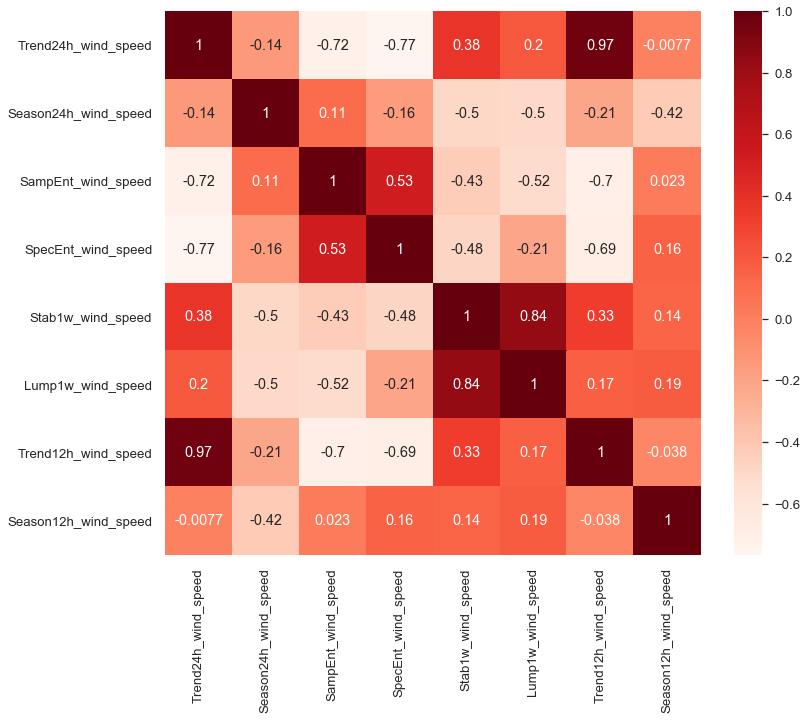

In [108]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [109]:
#lfs = lasso feature selection
lfs = LassoCV()
lfs.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % lfs.alpha_)
print("Best score using built-in LassoCV: %f" % lfs.score(X,Y))
coef = pd.Series(lfs.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000282
Best score using built-in LassoCV: 0.889472


In [110]:
print(coef)

Trend24h_wind_speed     10.350430
Season24h_wind_speed     3.341667
SampEnt_wind_speed      -0.303035
SpecEnt_wind_speed      -0.493277
Stab1w_wind_speed       -0.086388
Lump1w_wind_speed        0.122693
Trend12h_wind_speed      0.000000
Season12h_wind_speed    -3.192061
dtype: float64


In [111]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 1 variables


valores Season12h_wind_speed    -3.192061
SpecEnt_wind_speed      -0.493277
SampEnt_wind_speed      -0.303035
Stab1w_wind_speed       -0.086388
Trend12h_wind_speed      0.000000
Lump1w_wind_speed        0.122693
Season24h_wind_speed     3.341667
Trend24h_wind_speed     10.350430
dtype: float64


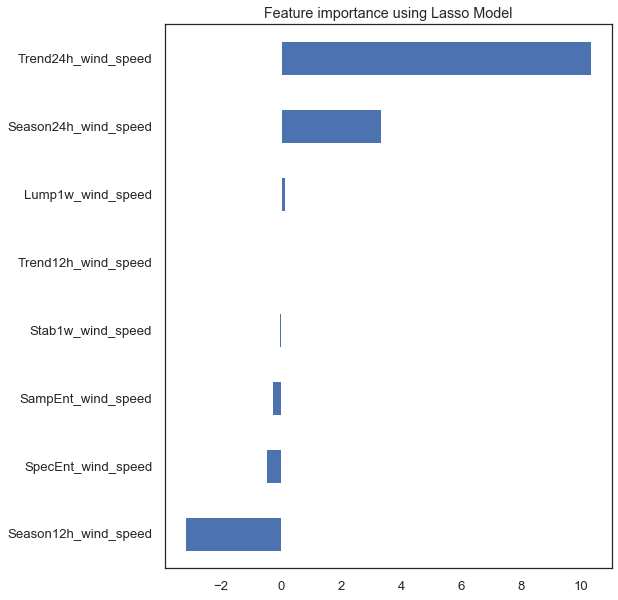

In [112]:
imp_coef = coef.sort_values()
print('valores', imp_coef)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [113]:
model_columns = [['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed',
                   'Trend12h_wind_speed','Season12h_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed',
                  'Season12h_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed'],
                 ['SampEnt_wind_speed', 
                  'SpecEnt_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed','SampEnt_wind_speed', 'Lump1w_wind_speed'],
                ]

In [114]:
model_columns[1]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
for cols in model_columns:
    X = data[cols]
    model_lasso.fit(X,Y)
#    print('(1)', model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
    NM2 = model_lasso.predict(X)
    df_NM2 = pd.DataFrame({'CNN_sep_2L': data.CNN_sep_2L, 'New Measure': NM2})
    correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
    print(cols)
    print('   ', X.shape, 'correlation :', correlation, 'R2 : ', model_lasso.score(X,Y))

['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed', 'Trend12h_wind_speed', 'Season12h_wind_speed']
    (126661, 8) correlation : 0.9383866753016524 R2 :  0.8801513043126483
['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed', 'Season12h_wind_speed']
    (126661, 7) correlation : 0.9383866582073824 R2 :  0.8801512711343963
['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed']
    (126661, 4) correlation : 0.9395930910354847 R2 :  0.8823235693196008
['Trend24h_wind_speed', 'Season24h_wind_speed']
    (126661, 2) correlation : 0.931142210049236 R2 :  0.8660613598212707
['SampEnt_wind_speed', 'SpecEnt_wind_speed']
    (126661, 2) correlation : 0.8694881973336672 R2 :  0.7559746906965019
['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'Lump1w_wind_speed']
    (126661, 4) 

### NON-linear model (SVM)

In [115]:
#data_sampled = data.sample(n=50000)
data_sampled = predictions
Y = data_sampled['CNN_sep_2L']
X = data_sampled[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='rbf'))
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))

0.9497058133449977


In [116]:
df_NM2 = pd.DataFrame({'CNN_sep_2L': data_sampled.CNN_sep_2L, 'New Measure': y_hat.tolist()})
correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L')

R2 regression 0.9497058133449977 correlation 0.9745623907439354
SVM CNN_sep_2L  corr:  0.9745623907439354 R2:  0.9497058133449977


In [117]:
# 6 h
Y = predictions['CNN_sep_2L_6h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.01, kernel='rbf'))
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
svm_rgr.score(X,Y)
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM','CNN_sep_2L_6h')
correlation = predictions['CNN_sep_2L_6h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

SVM CNN_sep_2L_6h  corr:  0.9836323090960768 R2:  0.967519909270688
R2 regression 0.967519909270688 correlation 0.9836323090960768


In [ ]:
# 1 h
Y = predictions['CNN_sep_2L_1h']
X = predictions[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.01, kernel='linear'))
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
print(svm_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM', 'CNN_sep_2L_1h')
correlation = predictions['CNN_sep_2L_1h'].corr(predictions['SVM'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

In [ ]:
tmp = predictions.sample(50000)
# Ridge
from sklearn.kernel_ridge import KernelRidge

Y = tmp['CNN_sep_2L_1h']
X = tmp[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
kr_rgr = make_pipeline(StandardScaler(), KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf'))
kr_rgr.fit(X,Y)
y_hat = kr_rgr.predict(X)
print(kr_rgr.score(X,Y))
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM')
correlation = predictions['CNN_sep_2L_1h'].corr(predictions['SVM'])
print("R2 regression", kr_rgr.score(X,Y), 'correlation', correlation, 'CNN_sep_2L_12h')

In [ ]:
predictions['SVM'] = y_hat.tolist()
correlaciones(predictions, 'SVM')

In [ ]:
# 126,661 sites 0.9497058133449977, 0.9745623907439354 126.000

In [ ]:
d = df_NM2

snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=d, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','SVM regression all measures')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("SVM regression ", fontsize=16)
snsplot.savefig('e:/figures/SVM_non_linear.png', dpi=300)

### Calculation of prediction R2 for all horizons

In [65]:
def R2_experiments(exp = 'JM_CNN_sep_2l_FULL'):
   query={'experiment':exp, 'status':'done'}
   # JM_RF_s2s_2, MLP_s2s_2
   results = DBResults(conn=mongolocal)
   results.retrieve_results(query)

   results.sample(1.0)


   a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
   a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
   a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

#   a = a[a[:,0].argsort()] # we sort by first column
   print(exp, ' 1h: ', np.mean(a1[:,1]), '6h: ', 
         np.mean(a6[:,1]), '12h :', np.mean(a12[:,1]))

In [71]:
R2_experiments(exp = 'JM_CNN_2L')

JM_CNN_2L  1h:  0.8174835755019033 6h:  4.396133597120384 12h : 7.2257681101353555


In [68]:
R2_experiments(exp = 'JM_CNN_sep_2l_FULL')
R2_experiments(exp = 'MLP_s2s_elu')
R2_experiments(exp = 'JM_RF_s2s_2')
R2_experiments(exp = 'CNN_s2s')
R2_experiments(exp = 'RNN_s2s')
R2_experiments(exp = 'knndir')
R2_experiments(exp = 'JM_MLP_s2s_best')
R2_experiments(exp = 'JM_RNN_best')
R2_experiments(exp = 'JM_CNN_2L')

JM_CNN_sep_2l_FULL  1h:  0.82088736238717 6h:  4.42892574604414 12h : 7.316929105499875
MLP_s2s_elu  1h:  0.8146303450127149 6h:  4.363824129569761 12h : 7.144507067783306
JM_RF_s2s_2  1h:  0.8016659235458674 6h:  4.240789491186854 12h : 6.770120707927505
CNN_s2s  1h:  0.8048932651721821 6h:  4.269704481604587 12h : 6.9088121036121635
RNN_s2s  1h:  0.8010001075716129 6h:  4.248444295903645 12h : 6.852182196280557
knndir  1h:  0.7384817839739892 6h:  3.5560782035582936 12h : 4.674979422670386
